In [2]:
import g3lhalo
import pyccl as ccl
import matplotlib.pyplot as plt
import numpy as np

# Example for defining the halo model ingredients

We show here how to define and plot the main halo model ingredients. We use `pyccl` for these definitions, but any functions can be passed.

## Defining model
We first initialize a model object. We will fill this with our ingredients in the following notebook. We set the verbosity to `true` to get better insights into what is happening

In [3]:
model=g3lhalo.halomodel(verbose=True)

## Defining cosmology

We define the cosmology we want to use. Note that currently only flat LCDM cosmologies are supported.

In [4]:
cosmo = {
    'Om_c': 0.28,
    'Om_b': 0.05,
    'h': 0.67,
    'sigma_8': 0.8,
    'n_s': 0.96
}

model.set_cosmo(cosmo)

Setting cosmology
Om_c: 0.28
Om_b: 0.05
h: 0.67
sigma_8: 0.8
n_s: 0.96
Also setting linear matter power spectrum


## Defining halo mass function

Now we define which halo mass function to use. We use here the `pyccl` implementation of the Sheth-Tormen HMF, but one can use *any* function that takes as arguments a mass and a redshift. 

In [5]:
hmf=ccl.halos.MassFuncSheth99()

model.set_hmf(hmf)


Setting halo mass function
<pyccl.halos.hmfunc.sheth99.MassFuncSheth99>
	mass_def = MassDef(Delta=fof, rho_type=matter)


Let's calculate the halo mass function for a certain mass range at redshift 0. Note that all masses are taken in solar masses, and all distances in Mpc (without $h$!)

Text(0, 0.5, 'Halo mass function $n(m, z=0)$ [Mpc$^{-3}\\, M_\\odot^{-1}$]')

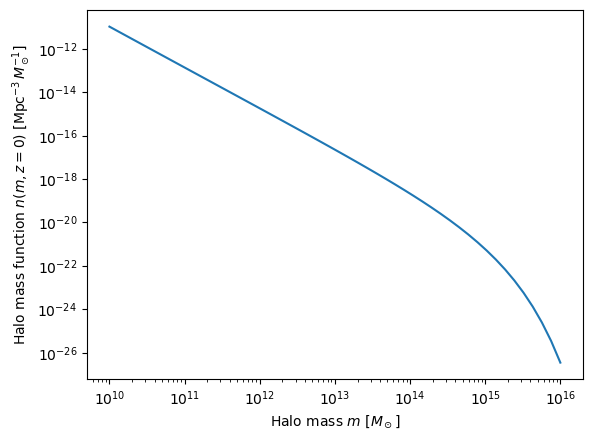

In [6]:
ms = np.geomspace(1e10, 1e16)
z = 0

n = model.dndm(ms, z)

plt.loglog(ms, n)

plt.xlabel(r'Halo mass $m$ [$M_\odot$]')

plt.ylabel(r'Halo mass function $n(m, z=0)$ [Mpc$^{-3}\, M_\odot^{-1}$]')

## Defining halo bias

We now define the halo bias. We are using here the Sheth (2001) halo bias, as defined by `pyccl` but any function of mass and redshift can be used.

In [7]:
hbf=ccl.halos.HaloBiasSheth01()
model.set_halobias(hbf)


Setting halo bias function
<pyccl.halos.hbias.sheth01.HaloBiasSheth01>
	mass_def = MassDef(Delta=fof, rho_type=matter)


Let us visualize the halo bias.

Text(0, 0.5, 'Halo bias $b_h(m, z=0)$')

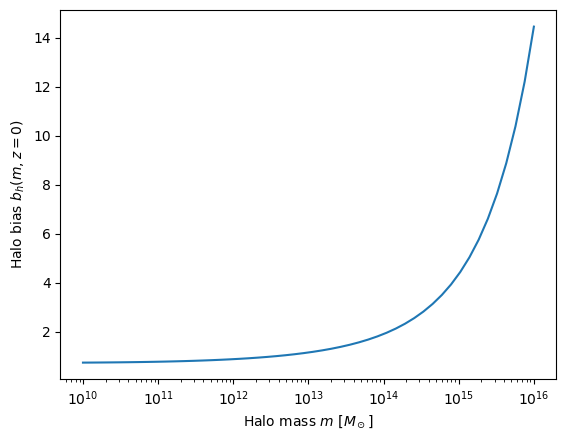

In [8]:
ms = np.geomspace(1e10, 1e16)
z = 0

b = model.bh(ms, z)

plt.xscale('log')

plt.plot(ms, b)

plt.xlabel(r'Halo mass $m$ [$M_\odot$]')

plt.ylabel(r'Halo bias $b_h(m, z=0)$')

## Defining Concentration-Mass Relation

Halos in this model follow NFW profiles with a certain concentration mass relation. As example we here use the Duffy (2008) definition, but any function of mass and redshift can be used.

In [9]:
cmfunc=ccl.halos.ConcentrationDuffy08()

model.set_concentration_mass_relation(cmfunc)


Setting concentration mass relation
<pyccl.halos.concentration.duffy08.ConcentrationDuffy08>
	mass_def = MassDef(Delta=200, rho_type=critical)
	mass_def_strict = True


With this definition, we can look at the normalised, Fourier-transformed halo profiles $\tilde{u}(k)$ of two halos of different masses

Text(0, 0.5, 'Normalized Fourierprofile $\\tilde{u}(k, m, z=0)$')

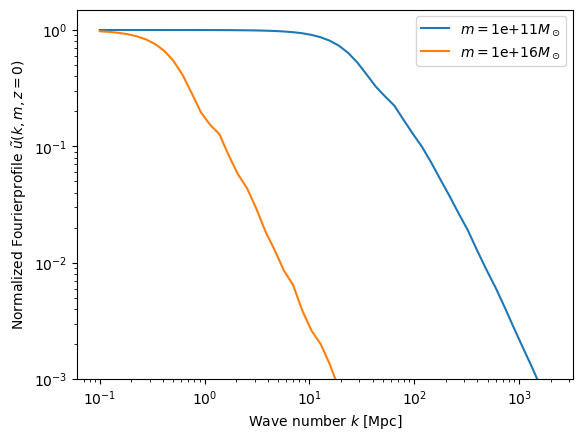

In [10]:
m1=1e11 #M_\odot
m2=1e16 #M_\odot

ks=np.geomspace(1e-1, 2e3) #1/Mpc

profile1=model.u_NFW(ks, m1, z=0.0)
profile2=model.u_NFW(ks, m2, z=0.0)

plt.loglog(ks, profile1, label=r"$m=$"+f"{m1:.0e}"+r"$M_\odot$")

plt.loglog(ks, profile2, label=r"$m=$"+f"{m2:.0e}"+r"$M_\odot$")

plt.legend()

plt.ylim(1e-3, 1.5)

plt.xlabel(r'Wave number $k$ [Mpc]')

plt.ylabel(r'Normalized Fourierprofile $\tilde{u}(k, m, z=0)$')



## Defining HODs

To calculate lens-lens and lens-source correlations we need to specify HOD models for central and satellite galaxies. Right now, these need to be functions of *only* halo mass. We can define up to two different HOD models. When only one HOD model is specified, the two galaxies in a lens-lens correlation are assuemd to be from the same population. We can also specify the parameters $A$ and $\epsilon$ that define the correlation between two galaxy populations. In this example, we use a Zheng 2005-like HOD, for which we first fix the parameters and assume no correlation.

In [11]:
# HOD parameters

alpha=1
sigma=0.2
Mth=1e12
Mprime=20*Mth
beta=1

# Correlation between galaxy populations
A=0 # 0 ==> No correlation between populations
epsilon=0

# Scaling of halo profile concentration
flens=1 # 1 ==> Same as dark matter


# Get HOD
hod_cen, hod_sat = g3lhalo.HOD_Zheng(alpha, Mth, sigma, Mprime, beta)

# Set HODs
model.set_hods(hod_cen, hod_sat, A=A, epsilon=epsilon, flens1=flens, flens2=flens)



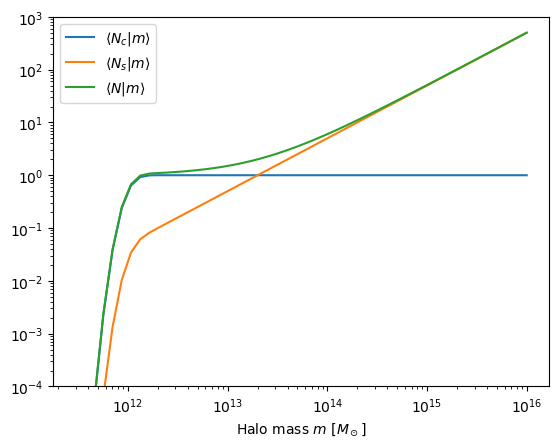

In [12]:
ms = np.geomspace(3e11, 1e16)

Ncen=model.hod_cen1(ms)
Nsat=model.hod_sat1(ms)

plt.loglog(ms, Ncen, label=r'$\langle N_c | m \rangle$')
plt.loglog(ms, Nsat, label=r'$\langle N_s | m \rangle$')
plt.loglog(ms, Nsat+Ncen, label=r'$\langle N | m \rangle$')



plt.xlabel(r'Halo mass $m$ [$M_\odot$]')

plt.ylim(1e-4, 1000)

plt.legend()

## Defining everything at once

The model class can also be directly initalized with the necessary quantities.

In [14]:
model2 = g3lhalo.halomodel(verbose=True, cosmo=cosmo, hmfunc=hmf, hbfunc=hbf, cmfunc=cmfunc)
model2.set_hods(hod_cen, hod_sat, A=A, epsilon=epsilon, flens1=flens, flens2=flens)



Setting cosmology
Om_c: 0.28
Om_b: 0.05
h: 0.67
sigma_8: 0.8
n_s: 0.96
Also setting linear matter power spectrum
Setting halo mass function
<pyccl.halos.hmfunc.sheth99.MassFuncSheth99>
	mass_def = MassDef(Delta=fof, rho_type=matter)
Setting halo bias function
<pyccl.halos.hbias.sheth01.HaloBiasSheth01>
	mass_def = MassDef(Delta=fof, rho_type=matter)
Setting concentration mass relation
<pyccl.halos.concentration.duffy08.ConcentrationDuffy08>
	mass_def = MassDef(Delta=200, rho_type=critical)
	mass_def_strict = True
